/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Im: (7, 480, 640, 3)
Calib: 7
[GRAPHCUT] step1 elapsed: 2.0746166706085205
[GRAPHCUT] step2 elapsed: 0.0337984561920166
[GRAPHCUT] step3 elapsed: 0.014719247817993164
[GRAPHCUT] step4 elapsed: 18.865514516830444
-------------------------------------------
Handle transitivity:
	Intra:		 16677
	Intra(choice):	 57
	Inter:		 23593
	Inter(choice):	 48268
-------------------------------------------
	Time =  149217  ms
	result: 0

	Total cost: 2149.094649479347

# valid points:		 291
# invalid points:	 15

-------------------------------------------
	Nu:	 306
	Iota:	 2761
	Lambda:	 2467
-------------------------------------------


#persons: 4
[GRAPHCUT] step5 elapsed 149.25139212608337
elapsed 170.40747499465942


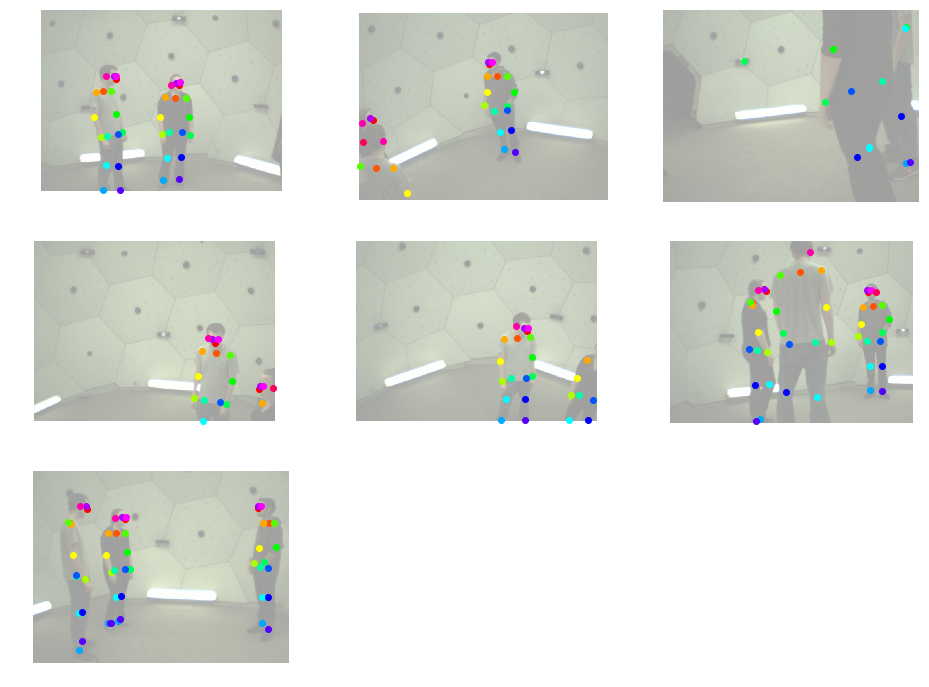

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

from poseestimation import model
pe = model.PoseEstimator()


USE_UMPM = False

if USE_UMPM:
    root = join(Settings['data_root'], 'pak')
    from pak.datasets.UMPM import UMPM
    user = Settings['UMPM']['username']
    pwd = Settings['UMPM']['password']
    
    X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)
    Human_Pose_Gt = Y

    # interesting frames: [340, 215, 250]
    # last one: 450
    FRAME = 0

    Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
    with_gpu = False

    if with_gpu:
        _start = time()
        heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
        _end = time(); print('elapsed:', _end - _start)
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                _start = time()
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
                _end = time()
                print('elapsed:', _end - _start)
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)
else:  # use CMU
    root = Settings['CMU']['data_root']
    
    FRAME = 2000
    
    panels = [1, 5,  6,  9, 10, 14, 15, 16, 18, 19]
    nodes = [ 1, 8, 15, 12,  6,  3, 12, 12, 13, 14]
    
    panels = [1,  6, 10, 14, 15, 18, 5]
    nodes = [ 1, 15,  6,  3, 12, 13, 8]
    
    seq_name = '160422_ultimatum1'
    
    Im, Y, Calib = tfm.get_from_cmu_panoptic(root, seq_name, 
                                            panels, nodes, 
                                            frame=FRAME)
    print("Im:", Im.shape)
    print("Calib:", len(Calib))
    
    hm_file = '/tmp/cmu_heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/cmu_pafs' + str(FRAME) + '.npy'

    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
mm_transform = 1 if USE_UMPM else 10  # CMU uses CM, not MM!!

_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True,
                             sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH/mm_transform
                            )
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2 if USE_UMPM else 3,2 if USE_UMPM else 3,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

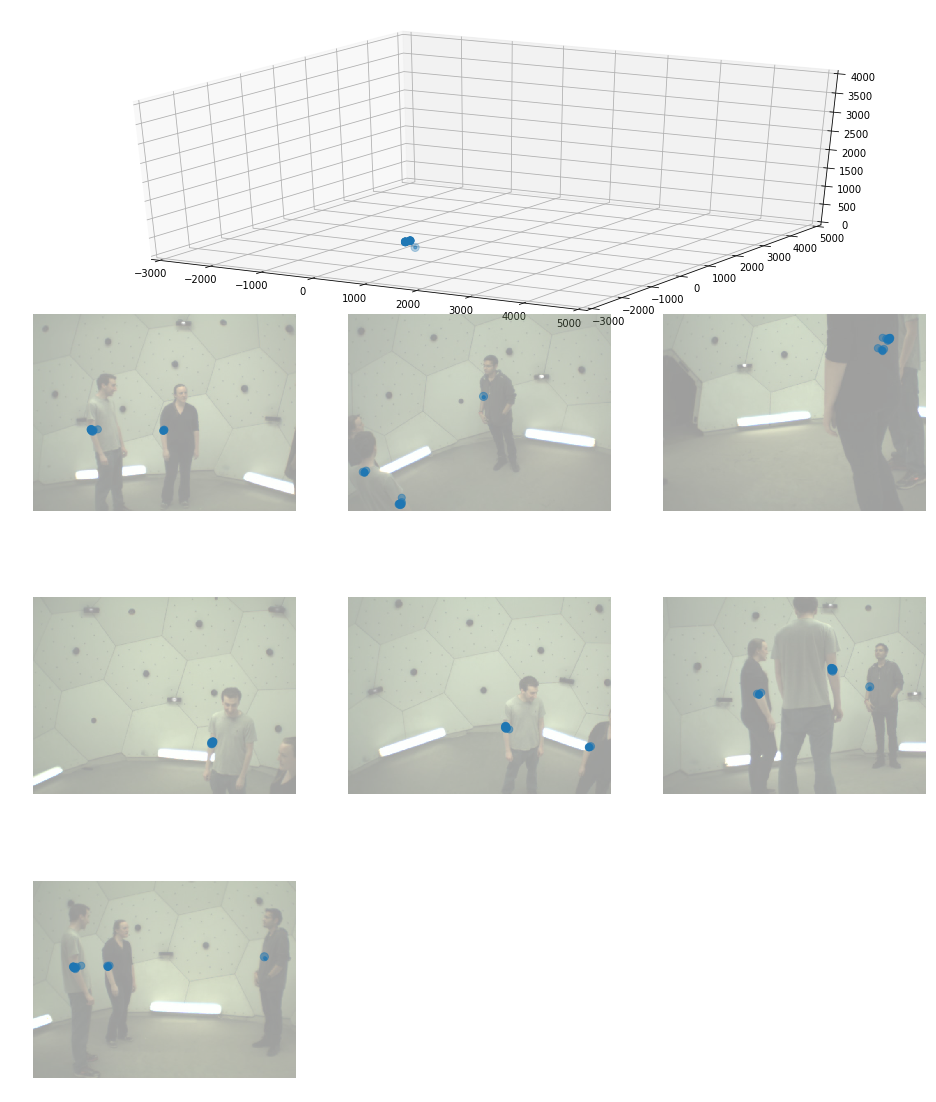

In [2]:
# 0 - Nose,  3 - relbow,  4 - rhand,  10 - rfoot,  12 - lknee,  13 - lfoot
JOINT_ID = 3

Noses = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])

X = Noses[:,0]
Y = Noses[:,1]
Z = Noses[:,2]
W = Noses[:,3] * Noses[:,4]

ax.scatter(X,Y,Z, s=W*100)

# --- reproject ---
Pts3d = Noses[:,0:3]
Pts3d = Pts3d.astype('float64')

for idx, cam in enumerate(Gr.Calib_undistorted):
    skip = 3 if USE_UMPM else 4
    ax = fig.add_subplot(3 if USE_UMPM else 4,2 if USE_UMPM else 3,skip+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    Noses2d = Gr.candidates2d[idx][JOINT_ID]
    #Noses2d = Gr.candidates2d_undistorted[idx][0]
    
    x = Noses2d[:,0]
    y = Noses2d[:,1]
    W = Noses2d[:,2] *  Noses2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100)
    
    
plt.show()

elapsed 0.17634129524230957


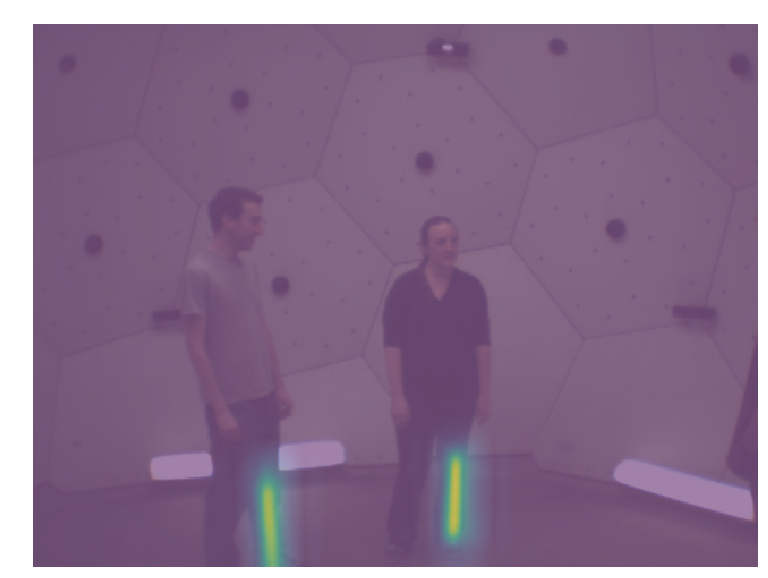

min: 1.631653156156338e-05
max: 1.0082433618000752


In [3]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.plot.limbs import draw_vector_field

assert len(DEFAULT_MAP_IDX) == len(DEFAULT_LIMB_SEQ)

cam = 0
LIMB_ID = 11
a,b = DEFAULT_MAP_IDX[LIMB_ID]

U = pafs[cam,:,:,a]
V = pafs[cam,:,:,b]

_start = time()
Vec = draw_vector_field(U, V)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.imshow(Im[cam], alpha=0.5)
ax.matshow(Vec, alpha=0.5)
ax.axis('off')
plt.show()


print('min:', np.min(Vec))
print('max:', np.max(Vec))

(12, 13)
skip camera  3
minimum of W: 0.0


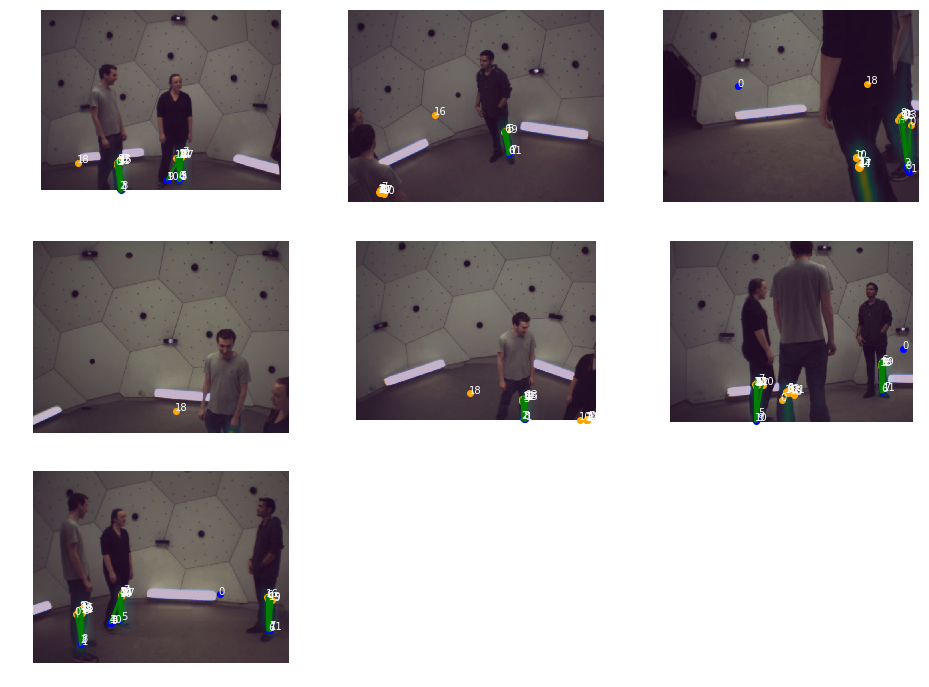

In [9]:
import numpy.linalg as la
from scipy.special import comb

cid = 2
LIMB_ID = 11

#cam = Calib[cid]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
print((a, b))
pafA, pafB = DEFAULT_MAP_IDX[LIMB_ID]
length_min, length_max = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]/mm_transform

candA3d = Gr.peaks3d_weighted[a]
candB3d = Gr.peaks3d_weighted[b]
nA = len(candA3d)
nB = len(candB3d)

W = np.zeros((nA, nB))

camera_normalization = comb(len(Calib), 2)

for cid, cam in enumerate(Calib):
    im = Im[cid]
    ax = fig.add_subplot(2 if USE_UMPM else 3,2 if USE_UMPM else 3,cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    U = pafs[cid,:,:,pafA]
    V = pafs[cid,:,:,pafB]

    h,w,_ = im.shape

    ptsA2d, maskA = gm.reproject_points_to_2d(
        candA3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
        binary_mask=True)
    ptsB2d, maskB = gm.reproject_points_to_2d(
        candB3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
        binary_mask=True)


    maskA = maskA == 1
    maskB = maskB == 1
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if is_A_on_screen:
            ax.scatter(ptA[0], ptA[1], color='orange')
            ax.text(ptA[0] + (-3 if i%2==0 else 3), ptA[1], str(i), color='white')

    for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
        if is_B_on_screen:
            ax.scatter(ptB[0], ptB[1], color='blue')
            ax.text(ptB[0] + (-3 if j%2==0 else 3), ptB[1], str(j), color='white')

    Vec = draw_vector_field(U, V)
    ax.imshow(Vec, alpha=0.3)

    

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ptA_candidates = []
    ptB_candidates = []
    pair_candidates = []
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if not is_A_on_screen:
            continue
            
        for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
            if not is_B_on_screen:
                continue
            distance = la.norm(ptA3d[0:3] - ptB3d[0:3])
            if length_min < distance < length_max:

                ptA_candidates.append(ptA)
                ptB_candidates.append(ptB)
                pair_candidates.append((i, j))
                
    if len(ptA_candidates) > 0 and len(ptB_candidates) > 0:
        line_int = mvpafs.calculate_line_integral_elementwise(
            np.array(ptA_candidates), np.array(ptB_candidates), U, V)

        assert len(line_int) == len(pair_candidates)
        line_int = np.squeeze(line_int/camera_normalization)
        
        if len(line_int.shape) == 0:
            line_int = np.expand_dims(line_int, axis=0)

        IDX = 0
        for w, (i,j) in zip(line_int, pair_candidates):
            W[i,j] += w

            Ax, Ay = np.squeeze(ptA_candidates[IDX])
            Bx, By = np.squeeze(ptB_candidates[IDX])
            IDX += 1

            if w > 0:
                ax.plot([Ax, Bx], [Ay, By], color='green', linewidth=w*100, alpha=0.7)
            elif w == 0:
                ax.plot([Ax, Bx], [Ay, By], color='gray', linewidth=3, alpha=0.7)
            else:
                ax.plot([Ax, Bx], [Ay, By], color='red', linewidth=-w*100, alpha=0.7)
    else:
        print('skip camera ', cid)
    
print("minimum of W:", np.min(W))

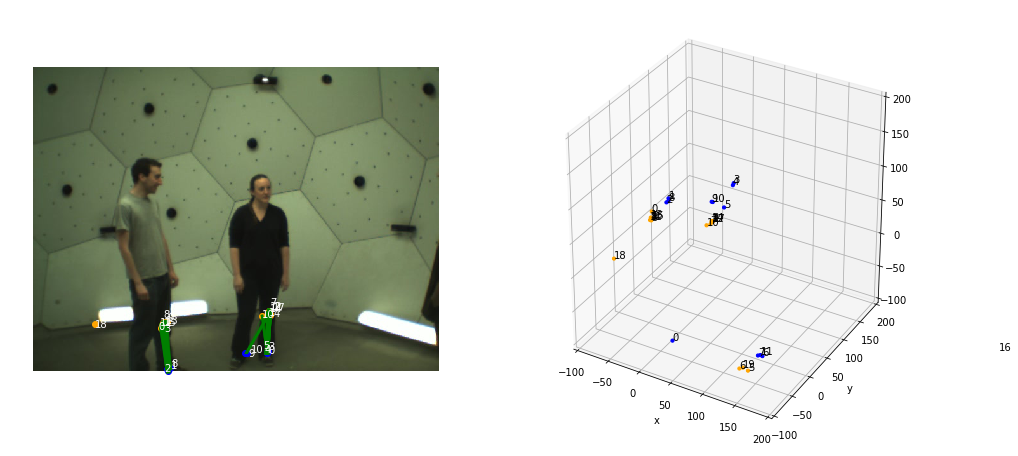

In [5]:
from numpy.random import randint

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)

cid = 0
cam = Calib[cid]
im = Im[cid]

a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
pafA, pafB = DEFAULT_MAP_IDX[LIMB_ID]
length_min, length_max = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]/mm_transform

candA3d = Gr.peaks3d_weighted[a]
candB3d = Gr.peaks3d_weighted[b]

ax.imshow(im)
ax.axis('off')


K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
U = pafs[cid,:,:,pafA]
V = pafs[cid,:,:,pafB]

h,w,_ = im.shape

ptsA2d, maskA = gm.reproject_points_to_2d(
    candA3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
    binary_mask=True)
ptsB2d, maskB = gm.reproject_points_to_2d(
    candB3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
    binary_mask=True)


maskA = maskA == 1
maskB = maskB == 1

for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
    if is_A_on_screen:
        ax.scatter(ptA[0], ptA[1], color='orange')
        ax.text(ptA[0] + randint(-7, 7), ptA[1] + randint(-7, 7), str(i), color='white')

for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
    if is_B_on_screen:
        ax.scatter(ptB[0], ptB[1], color='blue')
        ax.text(ptB[0] + randint(-7, 7), ptB[1] + randint(-7, 7), str(j), color='white')

Vec = draw_vector_field(U, V)
#ax.imshow(Vec, alpha=0.1)


# ==============================================

ptA_candidates = []
ptB_candidates = []
pair_candidates = []

for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
    if not is_A_on_screen:
        continue

    for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
        if not is_B_on_screen:
            continue
        distance = la.norm(ptA3d[0:3] - ptB3d[0:3])
        if length_min < distance < length_max:

            ptA_candidates.append(ptA)
            ptB_candidates.append(ptB)
            pair_candidates.append((i, j))

if len(ptA_candidates) > 0 and len(ptB_candidates) > 0:
    line_int = mvpafs.calculate_line_integral_elementwise(
        np.array(ptA_candidates), np.array(ptB_candidates), U, V)

    assert len(line_int) == len(pair_candidates)
    line_int = np.squeeze(line_int/camera_normalization)

    if len(line_int.shape) == 0:
        line_int = np.expand_dims(line_int, axis=0)

    IDX = 0
    for w, (i,j) in zip(line_int, pair_candidates):
        W[i,j] += w

        Ax, Ay = np.squeeze(ptA_candidates[IDX])
        Bx, By = np.squeeze(ptB_candidates[IDX])
        IDX += 1

        if w > 0:
            ax.plot([Ax, Bx], [Ay, By], color='green', linewidth=w*100, alpha=0.7)
        elif w == 0:
            ax.plot([Ax, Bx], [Ay, By], color='gray', linewidth=3, alpha=0.7)
        else:
            ax.plot([Ax, Bx], [Ay, By], color='red', linewidth=-w*100, alpha=0.7)
    
# ============================

ax = fig.add_subplot(122, projection='3d')
ax.set_xlim([-100, 200])
ax.set_ylim([-100, 200])
ax.set_zlim([-100, 200])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(candA3d[:,0], candA3d[:,1], candA3d[:,2], color='orange', alpha=1, s=10)
ax.scatter(candB3d[:,0], candB3d[:,1], candB3d[:,2], color='blue', alpha=1, s=10)
#ax.text(candA3d[:,0], candA3d[:,1], candA3d[:,2], '0123456789')
for i, (x, y, z) in enumerate(candB3d[:,0:3]):
    ax.text(x,y,z, str(i))

for i, (x, y, z) in enumerate(candA3d[:,0:3]):
    ax.text(x,y,z, str(i))


plt.show()

In [6]:
blue_0 = ptsB2d[0]
orange_7 = ptsA2d[7]

orange_7_3d = candA3d[7]
blue_0_3d = candB3d[0]

distance = la.norm(orange_7_3d[0:3] - blue_0_3d[0:3])

print('blue 0:\t\t', blue_0_3d[0:3])
print('orange 7:\t', orange_7_3d[0:3])

distance

blue 0:		 [ 35.55068652 -76.41305266 -63.95158579]
orange 7:	 [ 77.62077939 -45.16872784 102.47845385]


174.4851244105655

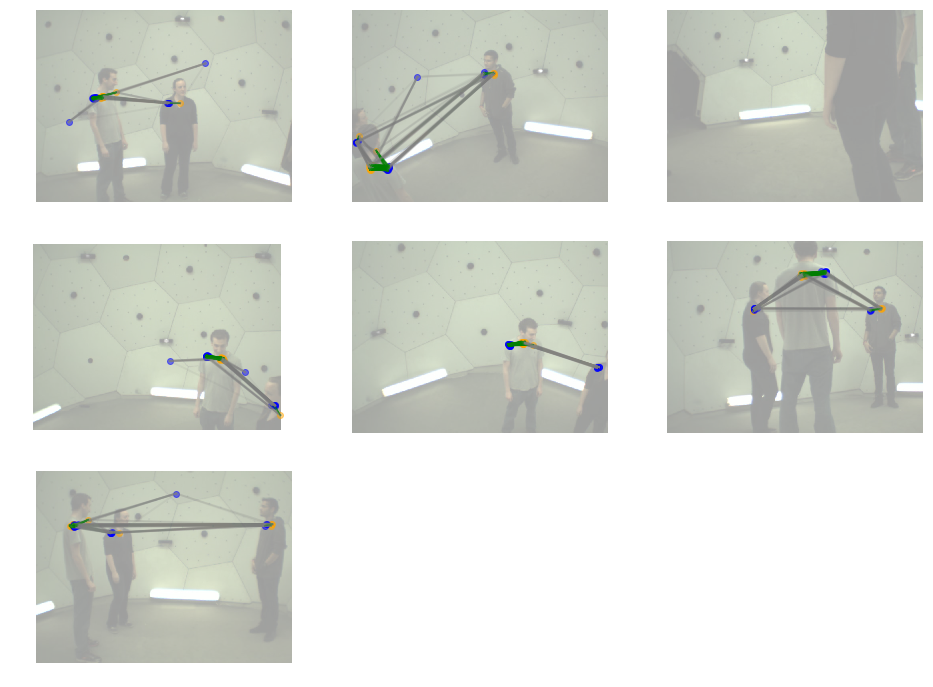

In [10]:
# take some random limb (left elbow -> hand left)
LIMB_ID = 0
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Gr.limbs3d[LIMB_ID]
n,m = W.shape
candA = Gr.peaks3d_weighted[a][:,0:3]
candB = Gr.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))

TOTAL = []

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2 if USE_UMPM else 3,2 if USE_UMPM else 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    
    ptsA2d, maskA = gm.reproject_points_to_2d(candA, rvec, tvec, K, w, h, distCoef=distCoef)
    ptsB2d, maskB = gm.reproject_points_to_2d(candB, rvec, tvec, K, w, h, distCoef=distCoef)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in maskA[0]:
        for _b in maskB[0]:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            TOTAL.append((idx, _a, _b, w))
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w == 0:
                ax.plot([Ax,Bx], [Ay,By], color='gray', linewidth=2, alpha=0.1)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

TOTAL = np.array(TOTAL)

plt.show()

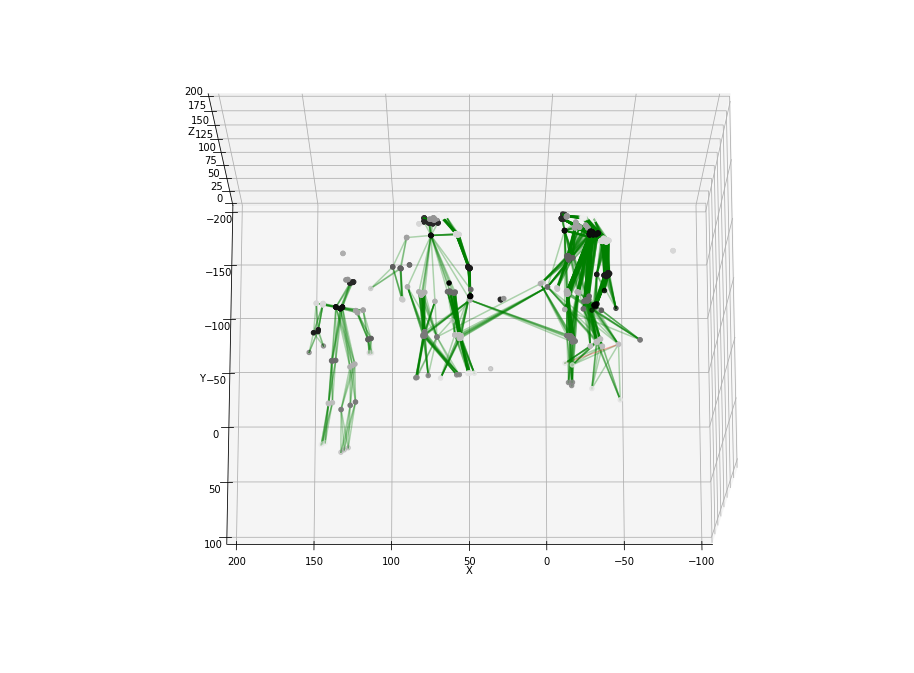

In [36]:
from random import shuffle

TOTAL = 19
COLORS = [(1/TOTAL*i,1/TOTAL*i,1/TOTAL*i) for i in range(TOTAL)]
shuffle(COLORS)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(75, 90)
ax.set_xlim([-100, 200])
ax.set_ylim([-200, 100])
ax.set_zlim([0, 200])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
    candA3d = Gr.peaks3d_weighted[a]
    candB3d = Gr.peaks3d_weighted[b]
    
    W = Gr.limbs3d[lid]
    n,m = W.shape
    assert n == len(candA3d) and m == len(candB3d)
    
    for x in range(n):
        for y in range(m):
            w = W[x,y]
            x1, y1, z1 = candA3d[x,0:3]
            x2, y2, z2 = candB3d[y,0:3]
            if w > 0:
                ax.plot([x1,x2], [y1,y2], [z1, z2], color='green', alpha=0.3)
            if w < 0:
                ax.plot([x1,x2], [y1,y2], [z1, z2], color='red', alpha=0.3)
    
    ax.scatter(candA3d[:,0], candA3d[:,1], candA3d[:,2],
              color=COLORS[a], alpha=1)
    ax.scatter(candB3d[:,0], candB3d[:,1], candB3d[:,2],
              color=COLORS[b])


plt.show()